In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from IPython.display import clear_output
import wandb

import numpy as np
import pylab as pl

from src import *

import sys
sys.setrecursionlimit(2000)

In [2]:
config = {
    'image':'firework.png',
    'growing_file':'Pretrained_models/bug/bug_persist.pt',
    'virus_file':'Pretrained_models/bug/Virus/bug_to_butterfly_google_8.pt',

    'target_size':40,
    'target_padding':8,
    'n_channels':15,
    'original_channel':-2,
    'virus_channel':-1,

    'pool_size': 32,
    'generator_iters_min':64,
    'generator_iters_max':96,
    'virus_rate':0.02,
    'square_side':3,

    'start_appling_loss':64,
    'start_appling_kill_loss':64,
    'kill_multiplier':1e-3,
    'perturbation_multiplier':1e-6,

    'lr':2e-3,
    'batch_size':6,
    'n_epochs':40,
    'n_max_loss_ratio':8,
    'evolution_iters':80,
    'kind':'persist',
    'skip_update':1,
    'skip_damage':1,
    'reset_prob':0,

    'step_size':20,
    'gamma':0.1,

    'trained_model_name': 'bug_to_butterfly'
    }

config["n_max_losses"] = max(1, config["batch_size"] // config["n_max_loss_ratio"])
config["image_size"] = config["target_size"] + config["target_padding"]

In [3]:
wandb.init(mode="disabled")
#wandb.init(project="Virus color", entity="neural_ca", config=config)

In [4]:
torch.backends.cudnn.benchmark = True # Speeds up things

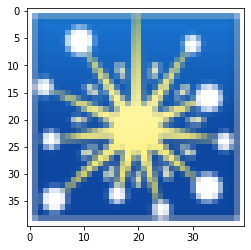

In [5]:
# Imports the target emoji
target = read_image("images/" + config["image"], ImageReadMode.RGB_ALPHA).float()
target = RGBAtoFloat(target)
target = T.ToPILImage()(target)
target = T.Resize((config["target_size"], config["target_size"]), interpolation=T.InterpolationMode.BILINEAR)(target)
target = T.ToTensor()(target)

imshow(target)

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(config["n_channels"], n_CAs=2, device=device)

In [166]:
model.CAs[0].load(config["growing_file"])
model.CAs[1].load(config["virus_file"])

Successfully loaded model!
Successfully loaded model!


In [8]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(config["n_channels"], config["original_channel"], config["virus_channel"], config["image_size"], 2, model,
                           iter_func=ExponentialSampler(min=config["generator_iters_min"], max=config["generator_iters_max"]),
                           virus_func=RandomVirus(config["virus_rate"]))
pool = SamplePool(config["pool_size"], generator)

In [9]:
losses = [NCALoss(pad(target, config["target_padding"]), alpha_channels=[-1, -2]),
          OldCellLoss()]
weights = [ConstantWeight(config["start_appling_loss"]),
           ConstantWeight(config["start_appling_kill_loss"], constant=config["kill_multiplier"])]

criterion = CombinedLoss(losses, weights)

#model.end_step_loss = NCADistance(model.CAs[1], starting_weights, config["perturbation_multiplier"])

In [ ]:
params = model.CAs[1].parameters()

optimizer = torch.optim.Adam(params, lr=config["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config["step_size"], config["gamma"])

model.train_CA(optimizer, criterion, pool, scheduler=scheduler, **config)

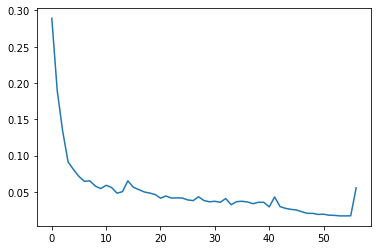

In [26]:
pl.plot(model.losses)

In [12]:
ruler.cosine_similarity(*model.CAs), ruler.distance(*model.CAs)

(tensor(0.6596, device='cuda:0'), tensor(0.1713, device='cuda:0'))

In [29]:
model.CAs[1].save(config["trained_model_name"] + ".pt", overwrite=True)

wandb.save(config["trained_model_name"] + ".pt")

Successfully saved model!


['/home/lettera/Desktop/neural_cellular_automata/pytorch_ca/wandb/run-20220131_114914-m9sqh0n4/files/bug_to_butterfly.pt']

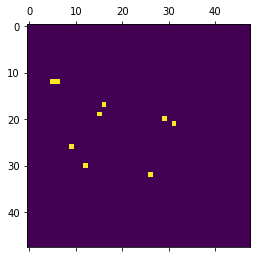

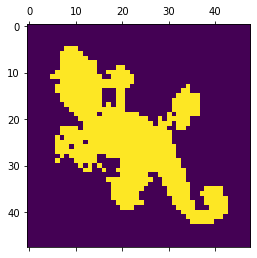

In [11]:
pl.matshow(image[0, -1].cpu()>0.1)
pl.matshow(image[0, -2].cpu()>0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


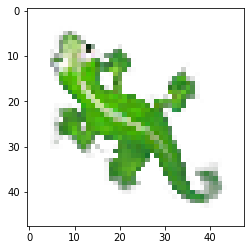

In [10]:
image = pool.sample(1)[0].detach().cuda()

imshow(state_to_image(image, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


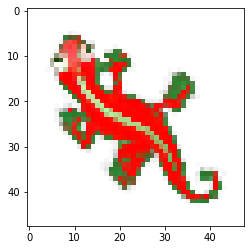

In [19]:
image = model.evolve(image, 20)

imshow(state_to_image(image, [-1, -2])[0])

In [38]:
# Log pool samples
imgs = []

for i in range(16):
    img = pool.sample(1)[0].detach().cpu()
    img = state_to_image(img, [-1, -2])[0]
    img = np.asarray(img.permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [110]:
# Lizard grow to persist
model.CAs[0].load("Pretrained_models/lizard/Virus/lizard_growing_until_160.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_grow_to_persist_squareside_4.pt")

Successfully loaded model!
Successfully loaded model!


In [106]:
# Buttefly grow to persist
model.CAs[0].load("Pretrained_models/butterfly/dying_butterfly.pt")
model.CAs[1].load("Pretrained_models/butterfly/Virus/growing_to_persist.pt")

Successfully loaded model!
Successfully loaded model!


In [84]:
# Firework grow to persist
model.CAs[0].load("Pretrained_models/firework/Virus/firework_growing_64_96.pt")
model.CAs[1].load("Pretrained_models/firework/Virus/firework_virus_ckp_50%.pt")

Successfully loaded model!
Successfully loaded model!


In [62]:
# Lizard green red
model.CAs[0].load("Pretrained_models/lizard/lizard_persist.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_persist_green_to_red_squareside_3.pt")

Successfully loaded model!
Successfully loaded model!


In [88]:
# Lizard no tail
model.CAs[0].load("Pretrained_models/lizard/lizard_persist.pt")
model.CAs[1].load("Pretrained_models/lizard/Virus/lizard_persist_to_no_tail.pt")

Successfully loaded model!
Successfully loaded model!


In [96]:
# Bug to butterfly
model.CAs[0].load("Pretrained_models/bug/bug_persist.pt")
model.CAs[1].load("Pretrained_models/bug/Virus/bug_to_butterfly_google_12.pt")

Successfully loaded model!
Successfully loaded model!


In [111]:
add_virus = RandomVirus(0.01).add_virus

In [115]:
converter=[tensor_to_RGB(function="RGBA",CA=model),
           tensor_to_RGB(function=[-2,-1],CA=model)]

seed=make_seed(1,config["n_channels"],config["image_size"],n_CAs=2,alpha_channel=config["original_channel"],device=device)
video,init_state=make_video(model,60,seed,converter=converter)
init_state=add_virus(init_state,-2,-1)
out, _=make_video(model,500,init_state,initial_video=video,converter=converter, regenerating=False)

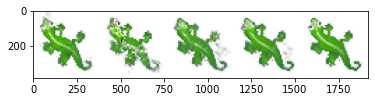

In [116]:
name = "lizard_grow_to_persist_1percent"
write_video(name+".mp4", torch.cat(out, dim=3).permute(0, 2, 3, 1), fps=15)

def plot_evolution(evolution, time_steps, fname):
    images = evolution.permute(0,2,3,1)[time_steps]/255

    images = rearrange(images, 'b h w c -> h (b w) c')

    pl.imshow(images)
    save_image(images.permute(2, 0, 1), fname)

slice = [60, 100, 150, 200, 500]
plot_evolution(out[1], slice, name + "_alpha.png")
plot_evolution(out[0], slice, name + ".png")

In [41]:
for name in ["virus_alpha.mp4", "virus.mp4"]:
    wandb.log({name: wandb.Video(name, fps=10)})